# Bayse Model 負の二項分布

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')
from patsy import dmatrix

import sys
import os
sys.path.append(os.path.abspath('../../../../../data_cleaning'))

from log_standardize import log_standardize

In [2]:
filepath = "../../../../../../data/processed/df_filtered_5years.xlsx"
df = pd.read_excel(filepath)
df = df.dropna()

## Difine variables

In [25]:
population = df['population']
bridge = df['dummy_after_bridge_opened']
pop_density = df['population'] / df['area_km2']

log_std_income = log_standardize(df['income'])
log_std_area = log_standardize(df['area_km2'])
log_std_dist = log_standardize(df['distance_m'])
log_std_density = log_standardize(pop_density)

X = dmatrix('log_std_income + log_std_area + log_std_dist + log_std_density', data=df, return_type='dataframe')
islands = dmatrix('C(island_id)', data=df, return_type='dataframe')
years = dmatrix('C(year)', data=df, return_type='dataframe')

n_x = X.shape[1]
n_islands = islands.shape[1]
n_years = years.shape[1]

# 過分散パラメータ
mean_population = np.mean(df['population'])
var_population = np.var(df['population'])

alpha = (var_population - mean_population) / mean_population**2
shape = 1 / alpha

## Define the model

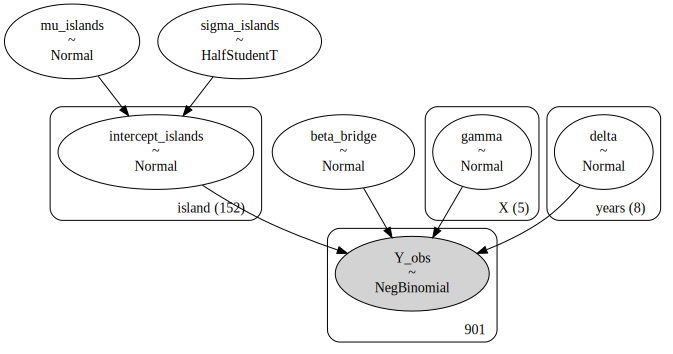

In [27]:
with pm.Model() as model:
    # Hyper-priors
    mu_islands = pm.Normal('mu_islands', mu=0, sigma=100)
    sigma_islands = pm.HalfStudentT('sigma_islands', nu=3, sigma=100)
    
    # prior
    intercept_islands = pm.Normal('intercept_islands', mu=mu_islands, sigma=sigma_islands, shape=n_islands, dims='island')
    beta_bridge = pm.Normal('beta_bridge', mu=0, sigma=100)
    gamma = pm.Normal('gamma', mu=0, sigma=100, shape=n_x, dims='X')
    delta = pm.Normal('delta', mu=0, sigma=100, shape=n_years, dims='years')

    # log link function
    lambda_ = pm.math.exp(beta_bridge * bridge + pm.math.dot(X, gamma) + pm.math.dot(islands, intercept_islands) + pm.math.dot(years, delta))

    # likelihood
    Y_obs = pm.NegativeBinomial('Y_obs', mu=lambda_, alpha=alpha, observed=population)


# view model
pm.model_to_graphviz(model)

In [ ]:
with model:
    idata = pm.sample(
        draws=1000,
        tune=2000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
        target_accept=.9,
        chains=2,
    )


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [67]:
az.to_netcdf(idata, './bm_covariates.nc')

'./bm_covariates.nc'

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_bridge,-0.009,0.027,-0.057,0.043,0.010,0.008,7.0,22.0,1.25
gamma[0],33.829,43.453,-39.734,119.254,23.855,18.623,3.0,12.0,1.63
gamma[1],0.026,0.011,0.010,0.048,0.002,0.002,25.0,71.0,1.05
gamma[2],1.535,0.014,1.506,1.555,0.003,0.002,19.0,33.0,1.07
gamma[3],0.024,0.012,-0.002,0.044,0.004,0.003,15.0,17.0,1.17
gamma[4],1.188,0.013,1.163,1.213,0.003,0.002,25.0,56.0,1.12
delta[0],-28.417,43.418,-113.808,45.105,23.828,18.601,3.0,12.0,1.63
delta[1],0.061,0.217,-0.285,0.398,0.128,0.102,3.0,45.0,1.61
delta[2],0.246,0.084,0.108,0.402,0.047,0.039,4.0,14.0,1.61
delta[3],0.236,0.084,0.110,0.415,0.047,0.039,4.0,12.0,1.64


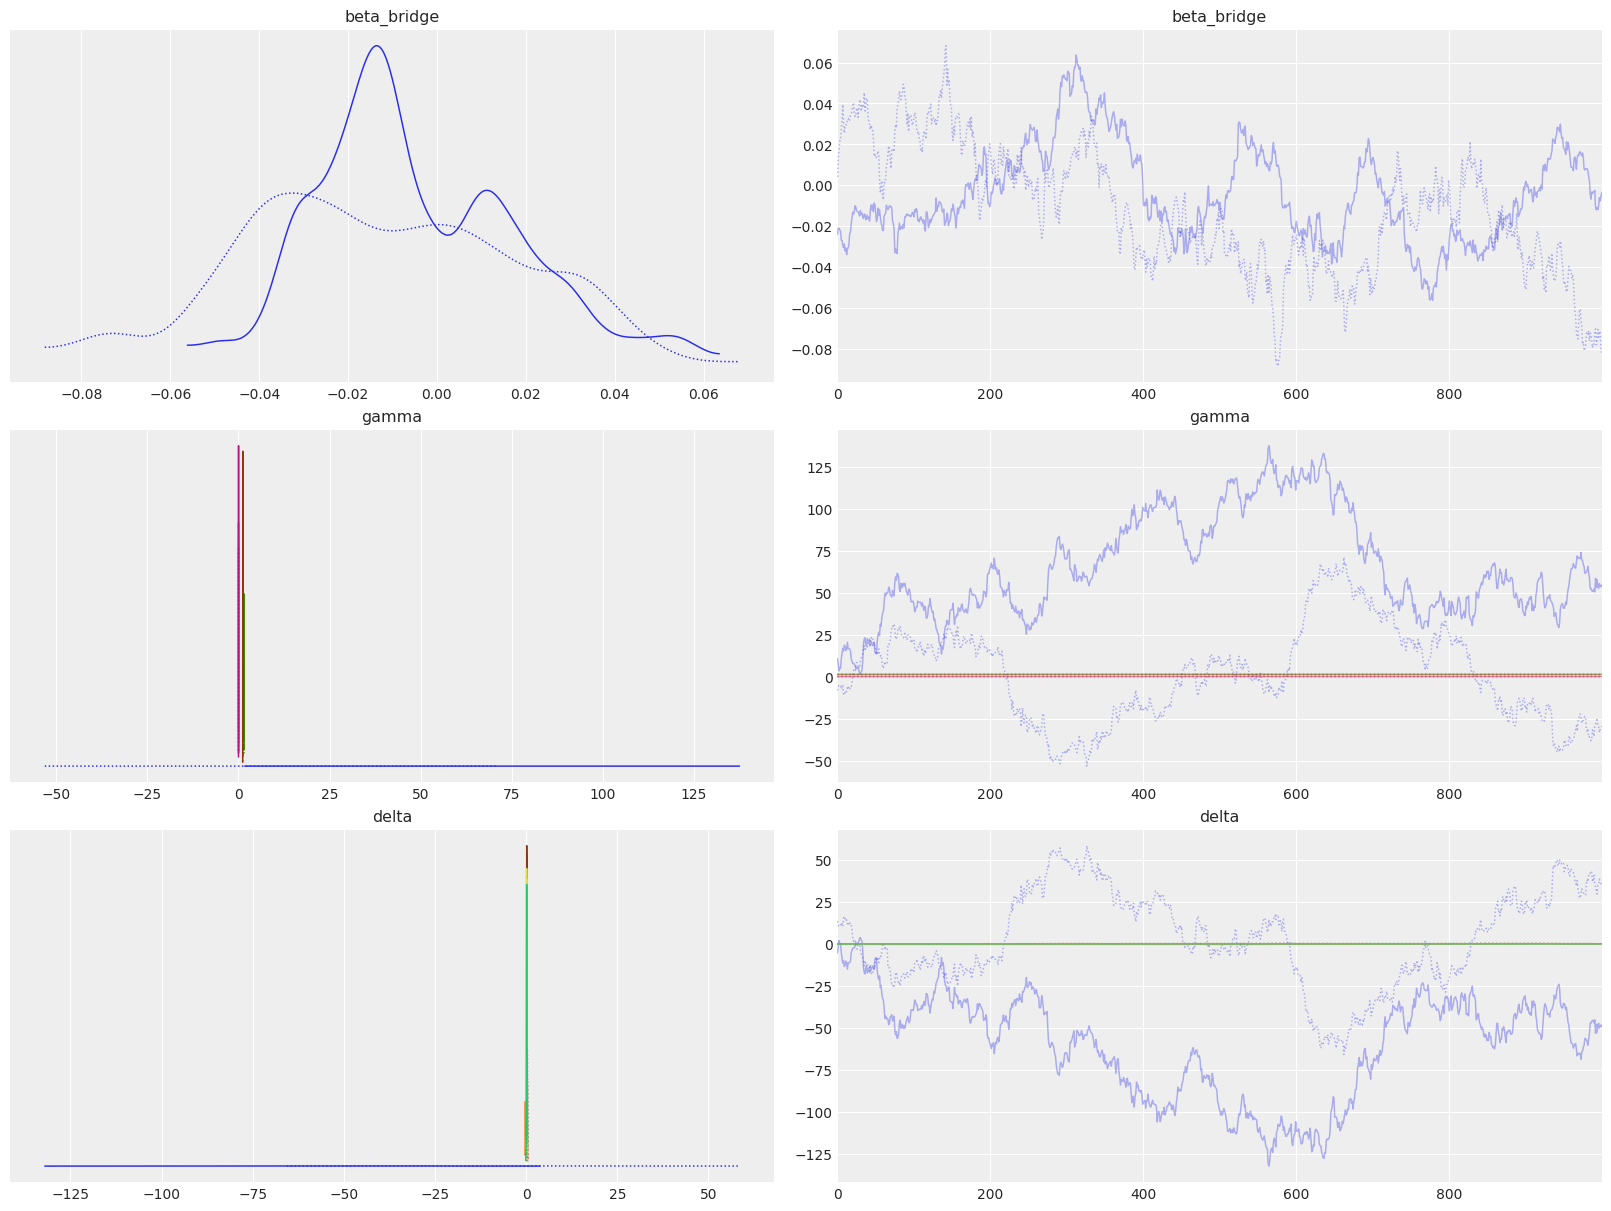

In [10]:
az.plot_trace(idata, figsize=(16, 12))  # サイズを調整
az.summary(idata)

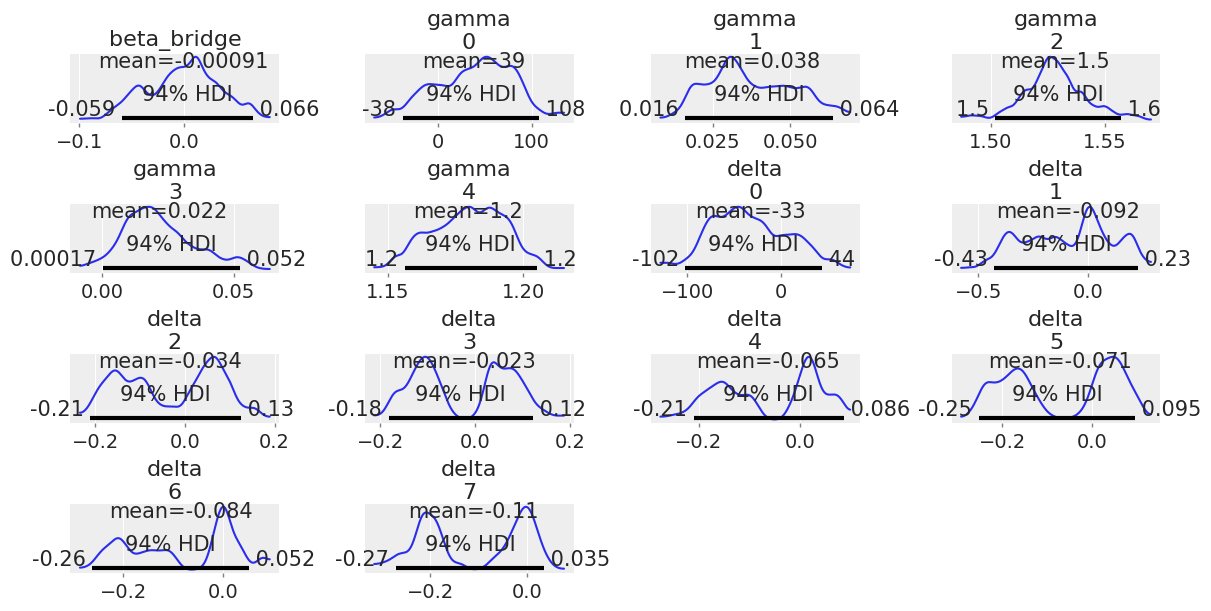

In [8]:
az.plot_posterior(idata, var_names=['beta_bridge', 'gamma', 'delta'], figsize=(12, 6));

# パラメータが0以上である確率

In [91]:
posterior_samples = idata.posterior

intercept_samples = posterior_samples['intercept']
beta_bridge_samples = posterior_samples['beta_bridge']
beta_income_samples = posterior_samples['gamma'][:, :, 0]
beta_area_samples = posterior_samples['gamma'][:, :, 1]
beta_distance_samples = posterior_samples['gamma'][:, :, 2]

# 0以上のサンプルの割合を計算
prob_beta_intercept_positive = np.mean(intercept_samples > 0)
prob_beta_bridge_positive = np.mean(beta_bridge_samples > 0)
prob_gamma_income_positive = np.mean(beta_income_samples > 0)
prob_gamma_area_positive = np.mean(beta_area_samples > 0)
prob_gamma_distance_positive = np.mean(beta_distance_samples > 0)

print(f"Pr(intercept > 0) = {prob_beta_intercept_positive:.4f}")
print(f"Pr(beta_bridge > 0) = {prob_beta_bridge_positive:.4f}")
print(f"Pr(gamma_income > 0) = {prob_gamma_income_positive:.4f}")
print(f"Pr(gamma_area > 0) = {prob_gamma_area_positive:.4f}")
print(f"Pr(gamma_distance > 0) = {prob_gamma_distance_positive:.4f}")

Pr(intercept > 0) = 1.0000
Pr(beta_bridge > 0) = 1.0000
Pr(gamma_income > 0) = 0.0070
Pr(gamma_area > 0) = 1.0000
Pr(gamma_distance > 0) = 0.0000


In [107]:
with pm.Model() as model:
    # 事前分布
    intercept = pm.Normal('intercept', mu=6.3, sigma=100)
    beta_bridge = pm.Normal('beta_bridge', mu=0.5, sigma=100)
    gamma = pm.Normal('gamma', mu=0, sigma=100, shape=3, dims='X')
    delta = pm.Normal('delta', mu=0, sigma=100, shape=3, dims='X')

    # 交差項の計算
    interaction = bridge * X

    # 対数リンク関数
    lambda_ = pm.math.exp(intercept + beta_bridge * bridge + pm.math.dot(X.T, gamma) + pm.math.dot(interaction.T, delta))

    # 尤度
    Y_obs = pm.NegativeBinomial('Y_obs', mu=lambda_, alpha=alpha, observed=population)


# モデルの視覚化
pm.model_to_graphviz(model)

ValueError: Length of values (3) does not match length of index (830)

In [104]:
with model:
    pm.compute_log_likelihood(idata)

Output()

ValueError: ['log_likelihood'] group(s) already exists.

In [99]:
loo = az.loo(idata)
loo

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 12000 posterior samples and 830 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -7901.05   177.87
p_loo       45.54        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      828   99.8%
   (0.70, 1]   (bad)         2    0.2%
   (1, Inf)   (very bad)    0    0.0%